# Simulation data

In [1]:
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]


def pwCDI(algo,iterations,DP,initial_guess,primary_inputs,shrinkwrap=False):
    """ Plane-wave CDI function

    Args:
        iterations (int): Total number of iterations_description_
        DP (numpy array): Diffraction pattern data
        initial_guess (numpy array): Initial guess for the object
        algo (string): Reconstruction algorithm to use. Options are: "ER", "HIO", ...
        primary_inputs (dict): Dictionary with the input parameters required by each different algorithm.
        
        primary_inputs = {  "support": np.ones((10,10)),
                            "distance": 2e-3,
                            "energy": 6,
                            "pixel_size: 20e-9,
                            "beta": 0.9,
                            "regularization_obj": 1,
                            "regularization_probe":1,
                            "modulator": np.ones((10,10))
                          }
    """    
    
    DP = np.sqrt(DP)
    DP, complex_obj = numpy_to_cupy(DP,initial_guess)
    
    """ Define secondary_inputs inputs """
    if algo == "ER":
        support = primary_inputs["support"]
    elif algo == "HIO": 
        support, beta = primary_inputs["support"], primary_inputs["beta"] # change params to dictionary!
        support = cupy.asarray(support)
        support_complement = cupy.array( 1-support )
    elif algo == "CMI":
        support   = primary_inputs["support"]
        modulator = primary_inputs["modulator"]
        distance  = primary_inputs["distance"]
        energy    = primary_inputs["energy"]
        reg_obj   = primary_inputs["regularization_obj"]
        reg_probe = primary_inputs["regularization_probe"]
        beta      = primary_inputs["beta"]
        object_pixel_size = primary_inputs["pixel_size"]

        if support.any() != None:
            support = cupy.asarray(support)
            support_complement = cupy.array( 1-support )
        else:
            support_complement = None
       
        modulator = numpy_to_cupy(modulator)

        probe = numpy_to_cupy(propagation_fresnel(modulator,distance,energy,object_pixel_size))
        complex_obj = cp.ones_like(modulator) # initialize object

        if beta != 0: 
            PR_algo = "HIO"
        else:
            PR_algo = "ER"
        # PR_algo = ""
        
        wavefront = complex_obj*probe
        
    for iteration in range(iterations):
        if iteration % 100 == 0: print("Iteration ",iteration)
        if shrinkwrap == True:
            support = update_support(complex_obj,support)
        
        if algo == "ER":
            complex_obj = ER(DP,complex_obj,support)
        elif algo == "HIO":
            complex_obj = HIO(DP,complex_obj,support,support_complement,beta)
        elif algo == "CMI":
            # if iteration <= 20:
            #     half_support = support.copy()
            #     half_support[0:support.shape[0]//2,0:support.shape[1]] = 0
            #     half_support_complement = cupy.array( 1-half_support )
            #     wavefront, complex_obj, probe = modulated_phase_retrieval(DP,complex_obj,probe, wavefront,modulator,distance,energy,object_pixel_size,half_support,half_support_complement,PR_algo,beta)
            # else:
            wavefront, complex_obj, probe = modulated_phase_retrieval(DP,complex_obj,probe, wavefront,modulator,distance,energy,object_pixel_size,support,support_complement,PR_algo,beta)
    
    wavefront, complex_obj, probe = cupy_to_numpy(wavefront, complex_obj, probe)
    
    if 1: #preview
        fig, ax = plt.subplots(1,3,dpi=300)
        ax[0].imshow(np.abs(wavefront)),   ax[0].set_title("Wavefront")
        ax[1].imshow(np.abs(complex_obj)), ax[1].set_title("Complex Obj")
        ax[2].imshow(np.abs(probe)),       ax[2].set_title("Probe")
        for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
    
    return wavefront

def ER(DP, wavefront, support):
    updated_wavefront = projection_M_gpu( wavefront, DP )
    wavefront = projection_S( updated_wavefront, support )
    return wavefront
    
def HIO(DP, wavefront, support, support_complement,beta):
    updated_wavefront = projection_M_gpu( wavefront, DP )
    wavefront = projection_S( updated_wavefront, support ) + projection_S( wavefront - beta * updated_wavefront,  support_complement )         
    return wavefront

def modulated_phase_retrieval(DP,complex_object,probe, wavefront,modulator,distance,energy,object_pixel_size,support,support_complement,algo="ER",beta=0.9,reg_obj=1,reg_probe=1):
    
    if distance > 0: #TODO: modulator after sample
        complex_object = None
        probe = None
        wavefront = None
    else: # modulator before sample
        probe = modulator_constraint(probe,modulator) 
        probe = propagation_fresnel(probe,distance,energy,object_pixel_size)
        wavefront = probe*complex_object
        previous_wavefront = wavefront
        
        wavefront = projection_M_gpu( wavefront, DP )
        if algo != "":
            if algo == "ER":
                # if np.isnan(np.min(wavefront)):  print("NAN")
                # else: print('good')
                wavefront = projection_S(wavefront,support)
            elif algo == "HIO":
                wavefront = projection_S( wavefront, support ) + projection_S( previous_wavefront - beta * wavefront,  support_complement )         
        probe = wavefront/complex_object
        complex_object, probe = update_obj_and_probe(complex_object,probe,wavefront,previous_wavefront,reg_obj,reg_probe) # update function of the PIE family
        probe = propagation_fresnel(probe,-distance,energy,object_pixel_size)
    return wavefront, complex_object, probe

def update_support(complex_obj,support):
    """ TODO: implement shrinkwrap update """
    return 0

def update_wavefront(original,auxiliary,current,previous,weight=1):
    updated = original + weight*auxiliary.conj()*(current-previous)/np.abs(np.max(auxiliary))**2
    return updated

def update_obj_and_probe(object,probe,wavefront,previous_wavefront,reg_obj=1,reg_probe=1):
    updated_object = object + reg_obj*probe.conj()*(wavefront-previous_wavefront)/np.abs(np.max(probe))**2
    updated_probe  = probe + reg_probe*object.conj()*(wavefront-previous_wavefront)/np.abs(np.max(object))**2
    return updated_object, updated_probe

def numpy_to_cupy(*args):
    output = []
    for arg in args:
        output.append(cupy.asarray(arg))
    if len(output)==1:
        return output[0]
    else:
        return output
    
def cupy_to_numpy(*args):
    output = []
    for arg in args:
        output.append(arg.get())
    if len(output)==1:
        return output[0]
    else:
        return output

def high_pass_filter_2D(img,cutoff):
    """ Cutoff value between 0 and ? """
    mask=np.zeros(img.shape)
    y,x = np.linspace(0,img.shape[0]-1,img.shape[0])-img.shape[0]//2,np.linspace(0,img.shape[1]-1,img.shape[1])-img.shape[1]//2
    Y,X = np.meshgrid(y,x)
    mask = np.where(X**2+Y**2<cutoff**2,0,1)
    FT = np.fft.fft2(img)
    filtered = mask*FT
    IFT = np.fft.ifft2(np.fft.fftshift(filtered))
    
    fig, ax = plt.subplots(1,3,dpi=250)
    ax1, ax2, ax3 = ax.ravel()
    ax1.imshow(mask)
    ax2.imshow(np.abs(FT),norm=LogNorm())
    ax3.imshow(mask*np.abs(FT),norm=LogNorm())
    
    return np.abs(IFT)
    
    
def get_support_from_AC(DP,threshold):
    """ Estimate support from auto-correlation """
    autocorr = np.fft.fftshift( np.fft.ifft2( DP ) )
    # autocorr = high_pass_filter_2D(autocorr,10)
    autocorr = np.abs(autocorr)
    
    autocorr -= np.min(autocorr)
    autocorr = autocorr/np.max(autocorr)
    
    support = np.where(autocorr>threshold*np.max(autocorr),1,0)
    return support, autocorr

def get_squared_support_from_AC(autocorrelation_threshold,delta):
    line, column = np.where(autocorrelation_threshold==np.max(autocorrelation_threshold))
    min_line, max_line = np.min(line), np.max(line)
    min_column, max_column = np.min(column), np.max(column)

    mean_column, mean_line = (max_column + min_column)//2, (max_line + min_line)//2
    thickness = max_column - min_column
    height = max_line - min_line

    # get half the AC mask as the support coordinates
    line_start, line_end = mean_line - height//4 - delta, mean_line + height//4 + delta # delta é um chorinho
    column_start, column_end = mean_column - thickness//4 - delta, mean_column + thickness//4 + delta
    
    support = np.zeros_like(autocorrelation_threshold)
    support[line_start:line_end,column_start:column_end] = 1
    return support

def get_modulator1(matrix):
     return np.random.rand(*matrix.shape)
    
def propagation_fresnel(E0, z,energy,ps ):
    speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]

    # Parameters: E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    E0 = E0
    lambda0 = 1e9 * planck * speed_of_light / energy # nanometers
    ps = ps*1e6 #microns
    
    upsample_scale = 1;                 # Scale by which to upsample image
    n = upsample_scale * E0.shape[1] # Image width in pixels (same as height)
    grid_size = ps * n;                 # Grid size in x-direction
    

    # Inverse space
    fx = cp.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    fy = cp.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    Fx, Fy = cp.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2)); 
    # sphere=exp(i*k/2/zc*(xx.^2+yy.^2));
    H = cp.exp(1j*(2 * cp.pi / lambda0) * z) * cp.exp(1j * cp.pi * lambda0 * z * (Fx**2 + Fy**2)) # (4.21)
    #H= cos(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0)+1i.*sin(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0);
    
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    
    # Multiply spectrum with fresnel phase-factor
    G = H * E0fft
    Ef = iFT(G) # Output after deshifting Fourier transform
    
    return Ef

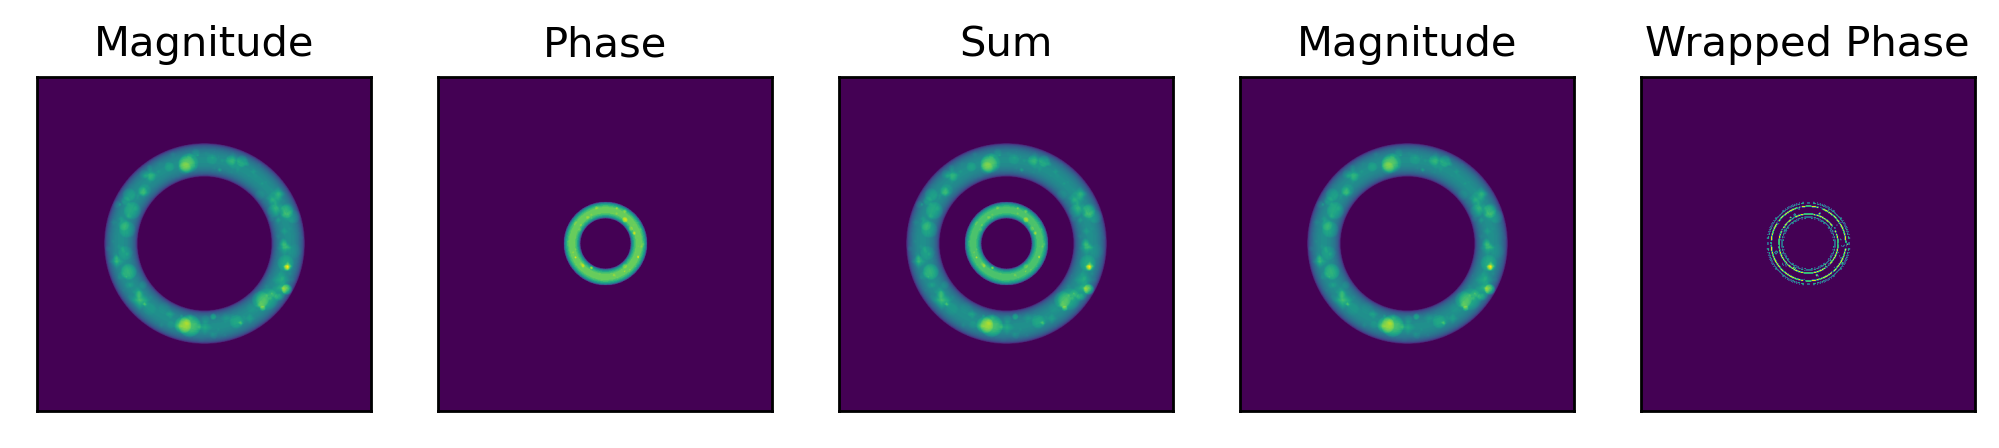

(None, None)

In [2]:
from PWCDI import *

speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
N = 100

""" Load model """
model = np.ones((N,N))
calculate_error = True # flag to calculate error against model at each iteration
error = []

""" Input parameters """
distance = 28 # meters
energy = 6 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters
n_of_pixels = 3072 
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,distance)
distance_pinhole = 0.21e-3 # m
phase_retrieval_iterations = 300
reg_obj,reg_probe = 0.1, 0.2# PIE update function parameters
apply_support = True
beta = 0.9

""" Load phantom """
if 1: # Complex donut
    path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/"
    magnitude = np.load(os.path.join(path,'magnitude.npy'))
    phase = np.load(os.path.join(path,'phase.npy'))
    magnitude, phase = np.sum(phase,axis=0), np.sum(magnitude,axis=0)
    phase = 3*phase

    # P = 200
    # magnitude = np.pad(magnitude,((P,P),(P,P)))
    # phase = np.pad(phase,((P,P),(P,P)))
    
    # magnitude = np.roll(magnitude,(10,10))
    # phase = np.roll(phase,(-10,-10))
    phantom = magnitude*np.exp(1j*phase)
else: # Célula
    phantom = np.load("ptychocell.npy")[0]
    magnitude = np.abs(phantom)
    phase = np.angle(phantom)
    phantom = np.squeeze(phantom)[300:1100,300:1100]
    
figure, ax = plt.subplots(1,5,dpi=250,figsize=(10,5))
ax1, ax2, ax3, ax4, ax5 = ax.ravel()
ax1.imshow(magnitude), ax1.set_title('Magnitude')
ax2.imshow(phase), ax2.set_title('Phase')
ax3.imshow(magnitude+phase), ax3.set_title('Sum')
ax4.imshow(np.abs(phantom)), ax4.set_title("Magnitude")
ax5.imshow(np.angle(phantom)), ax5.set_title("Wrapped Phase")
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
plt.show(), plt.close()

(500, 500)


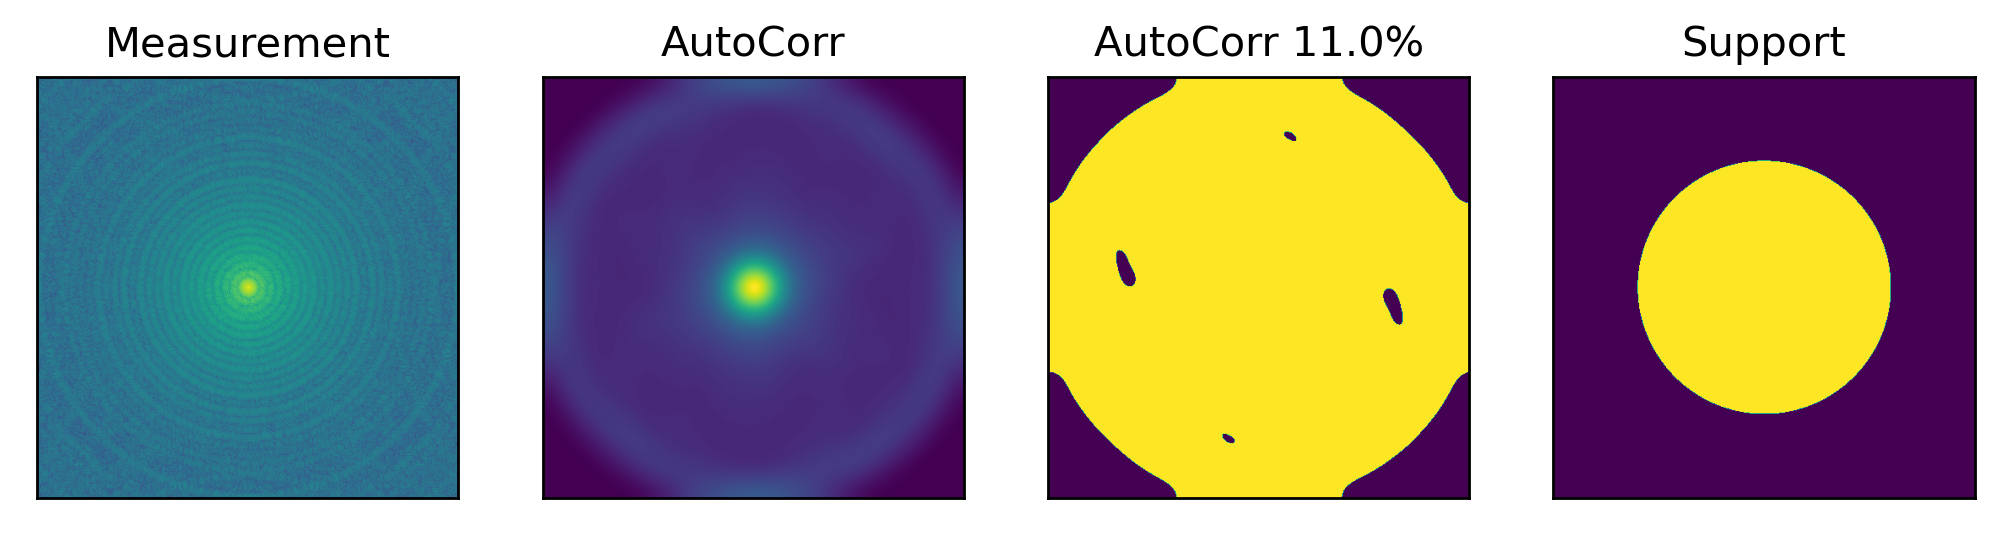

(None, None)

In [3]:
threshold = 0.11

""" Load data """
DP = np.abs( np.fft.fftshift( np.fft.fft2(phantom) ) )**2 
np.save("complex_donuts_intensity.npy",DP)
object = np.ones_like(DP,dtype=complex)
print(DP.shape)

autocorrelation_threshold, autocorrelation = get_support_from_AC(DP,threshold)
support = get_squared_support_from_AC(autocorrelation_threshold,80)

if 1: #tight_support
    support = np.where(np.abs(phantom) > 0,1,0)
    N = phantom.shape[0]
    x = np.linspace(0,N-1,N) - N//2
    Y,X = np.meshgrid(x,x)
    support2 = np.where((X-0)**2+(Y-0)**2<150**2,1,0)
    pinhole = np.where((X-0)**2+(Y-0)**2<200**2,1,0)
    support = support2+support
    support = np.where(support >= 1, 1,0)
    half_support = support.copy()
    half_support[0:support.shape[0]//2,0:support.shape[1]] = 0

figure, ax = plt.subplots(1,4,dpi=250,figsize=(10,5))
ax1, ax2, ax3, ax4 = ax.ravel()
ax1.imshow(DP,norm=LogNorm()), ax1.set_title('Measurement')
ax2.imshow(autocorrelation), ax2.set_title('AutoCorr')
ax3.imshow(autocorrelation_threshold), ax3.set_title(f'AutoCorr {threshold*100}%')
ax4.imshow(support), ax4.set_title(f'Support')
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
plt.show(), plt.close()

Iteration  0
Iteration  100
Iteration  200


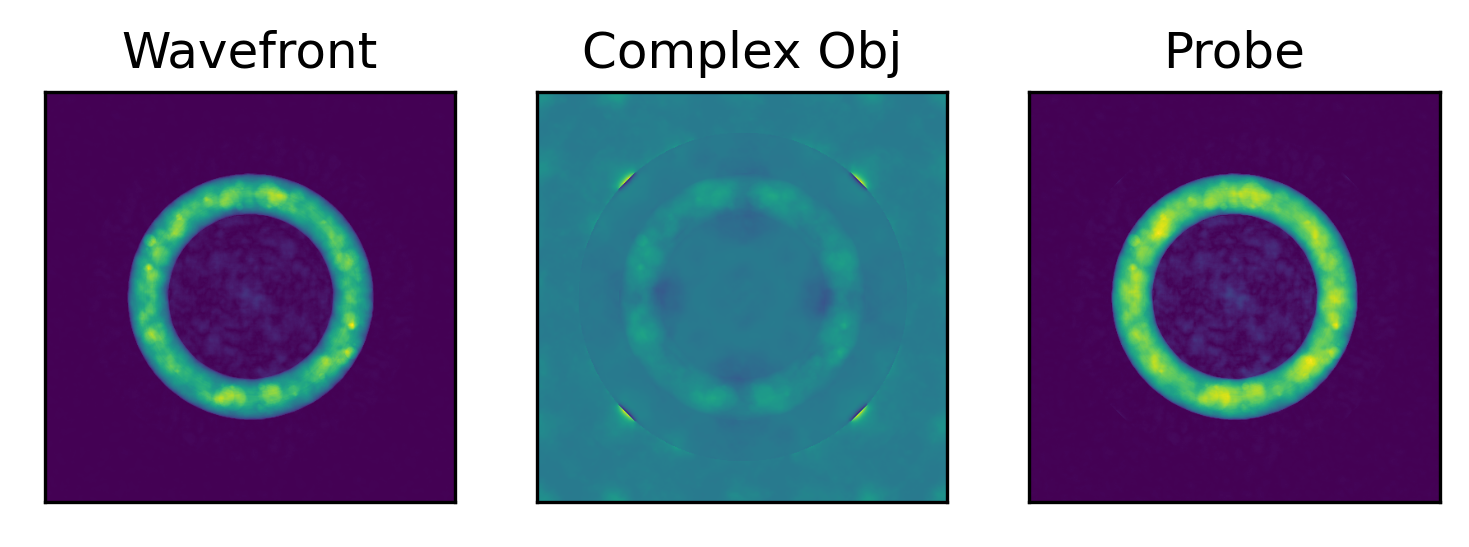

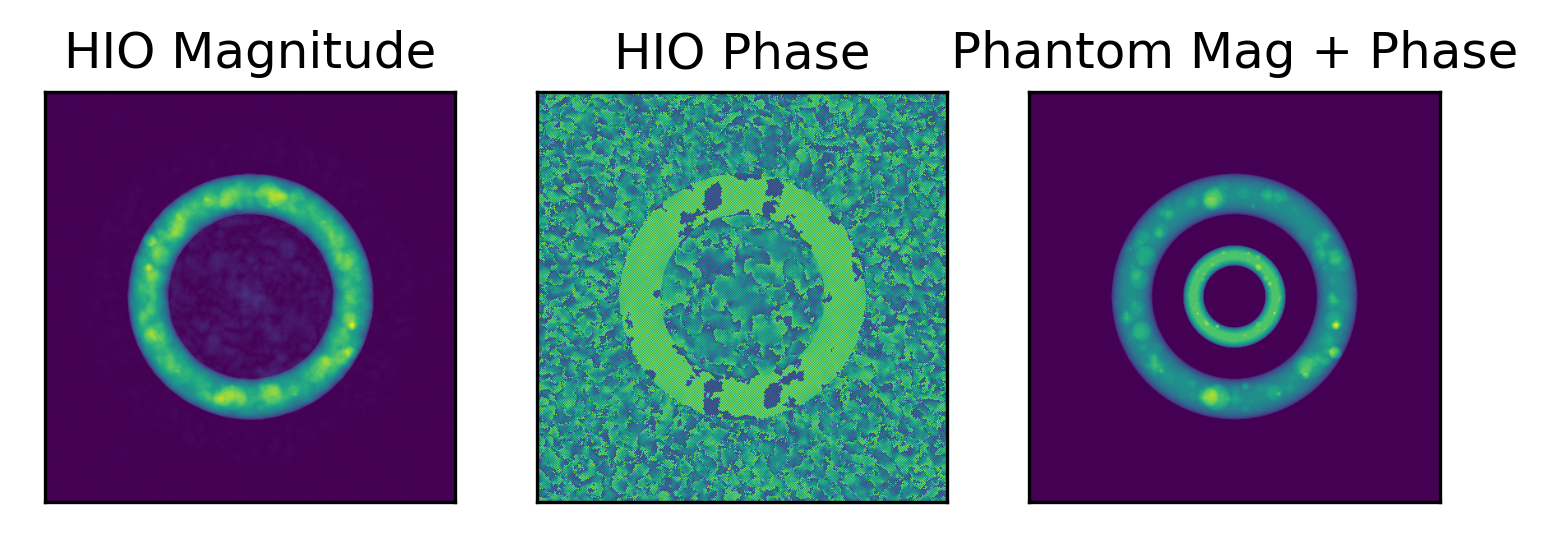

In [4]:
import cupy as cp
initial_guess = np.ones_like(support)

if 0: # benchmark
    primary_inputs = {  "support": cp.asarray(support),
                        "distance": -distance_pinhole,
                        "energy": energy,
                        "pixel_size": object_pixel_size,
                        "beta": 0,
                        "regularization_obj": 1,
                        "regularization_probe":1,
                        "modulator": np.ones((10,10))
                      }

    # ER with half support
    primary_inputs["support"] = cp.asarray(half_support)
    recon = np.squeeze(pwCDI("ER",10,DP,initial_guess,primary_inputs,shrinkwrap=False))

    primary_inputs["support"] = cp.asarray(support)
    iterations = 1000
    recon = np.squeeze(pwCDI(algo,iterations,DP,recon,primary_inputs,shrinkwrap=False))

    algo = "ER"
    iterations = 50
    recon = np.squeeze(pwCDI(algo,iterations,DP,recon,primary_inputs,shrinkwrap=False))
else:
    iterations = 300
    primary_inputs = {  "support": support,
                        "distance": -distance_pinhole,
                        "energy": energy,
                        "pixel_size": object_pixel_size,
                        "beta": 0.9,
                        "regularization_obj": 0.1,
                        "regularization_probe":0.9,
                        "modulator": pinhole,#np.ones_like(support),
                  }
    recon = np.squeeze(pwCDI("CMI",iterations,DP,initial_guess,primary_inputs,shrinkwrap=False))


    
fig, ax = plt.subplots(1,3,dpi=300)
ax[0].imshow(np.abs(recon)), ax[0].set_title("HIO Magnitude")
ax[1].imshow(np.angle(recon)), ax[1].set_title("HIO Phase")
ax[2].imshow(magnitude+phase), ax[2].set_title("Phantom Mag + Phase")
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
